---

_This notebook has been modifie from the **version 1.0** of the cousera course 'Applied Machine Learning in Python
Applied Machine Learning in Python, University of Michigan'. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

### Content

* [Intro](#intro)
* [Naive Bayes classifiers](#NBC)
* Ensambles of Decision Trees
    * [Random Forest](#RF)
    * [Gradient-boosted decision trees](#GBDT)
* [Neural Networks](#NN)    

# Applied Machine Learning: Module 4 (Supervised Learning, Part II)

<a id="intro"></a> 
## Intro

This week we'll bring together the machine learning methods we've covered in previous weeks of this course, and discuss some important issues and best practices for how to apply these machine learning methods on real world problems. 

* You'll learn about how to perform feature engineering through developing and analyzing feature representations. 
* You'll understand the problem of data leakage. Why it's important and how to avoid it. 
* We'll discuss some useful rules for selecting the right machine learning approach for a given problem, and go over some best practices when integrating machine learning methods into software projects. 

<img src="module4_intro_1.png" alt="jupyter" style="width: 900px;"/> 

I'm going to summarize some of these examples of rules of thumb I've learned through my own work, as well as recommendations that other data scientists have shared with me. In the end, all of this will hopefully help you get the most out of applying machine learning in your projects. 

Let's first return to this diagram of the **iterative machine learning development proces ( Represent/Train/evaluate/Refine cycle for model development)**. We saw how developing a machine learning model involved four stages that could be repeated in a cycle, from *representing the data as a set of features to training a model, evaluating its performance on held out data, and then refining the features in the model to improve performance further by optimizing an objective*.

<img src="module4_intro_2.png" alt="jupyter" style="width: 900px;"/> 

Let's adjust this diagram slightly to reflect the fact that there is a set of processes that are **shared between the training and test stage and the prediction stage for future instances**. We've included a feature and model refinement stage here as part of the process but graded out to emphasize the shared series of processes that take data through the stages of **extraction, feature representation, application to a machine learning model, and evaluation. This series of processes is called, The Machine Learning Pipeline**. This Pipeline is used both with training and test instances during model development, and on future instances for prediction.

<img src="module4_intro_3.png" alt="jupyter" style="width: 900px;"/> 

We have the option of a refinement step either as the result of model development or as the result of deploying and evaluating the system on future data. Our focus this week will be on the **development phases** that are associated with a typical software project using machine learning and practice. 

<img src="module4_intro_4.png" alt="jupyter" style="width: 900px;"/> 

This involves three steps: setting up the initial end-to-end **pipelined infrastructure** to get something working and test the basic data extraction and manipulation processes, doing **feature engineering** to get useful features into the pipeline, and then a **refinement stage** to get feedback from evaluation that can be used to further improve the results. We'll cover some specifics of the feature engineering stage, as well as describe the problem of **data leakage when information about what we're trying to predict is accidentally present in the training data**. We'll also cover for each of these three development phases some software engineering rules of thumb that may help save you time and effort when deploying a real system. 

<img src="module4_intro_5.png" alt="jupyter" style="width: 900px;"/> 

## Preamble and Datasets

<IPython.core.display.Javascript object>


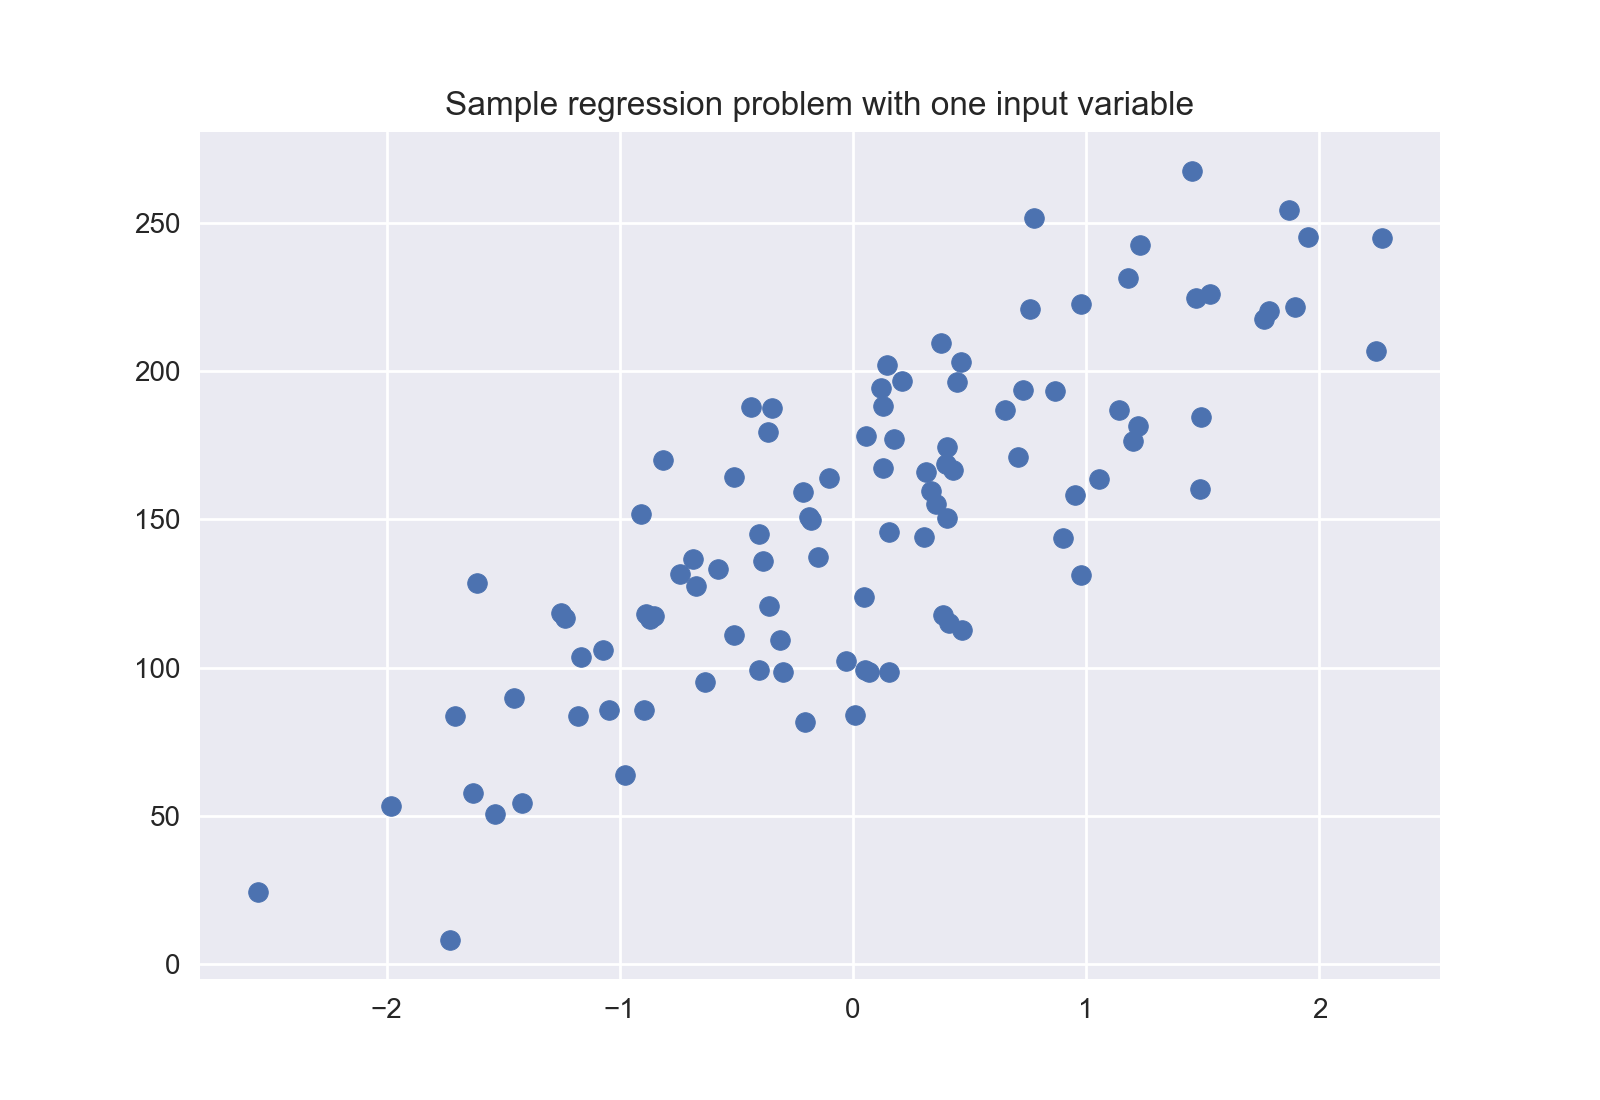

<IPython.core.display.Javascript object>


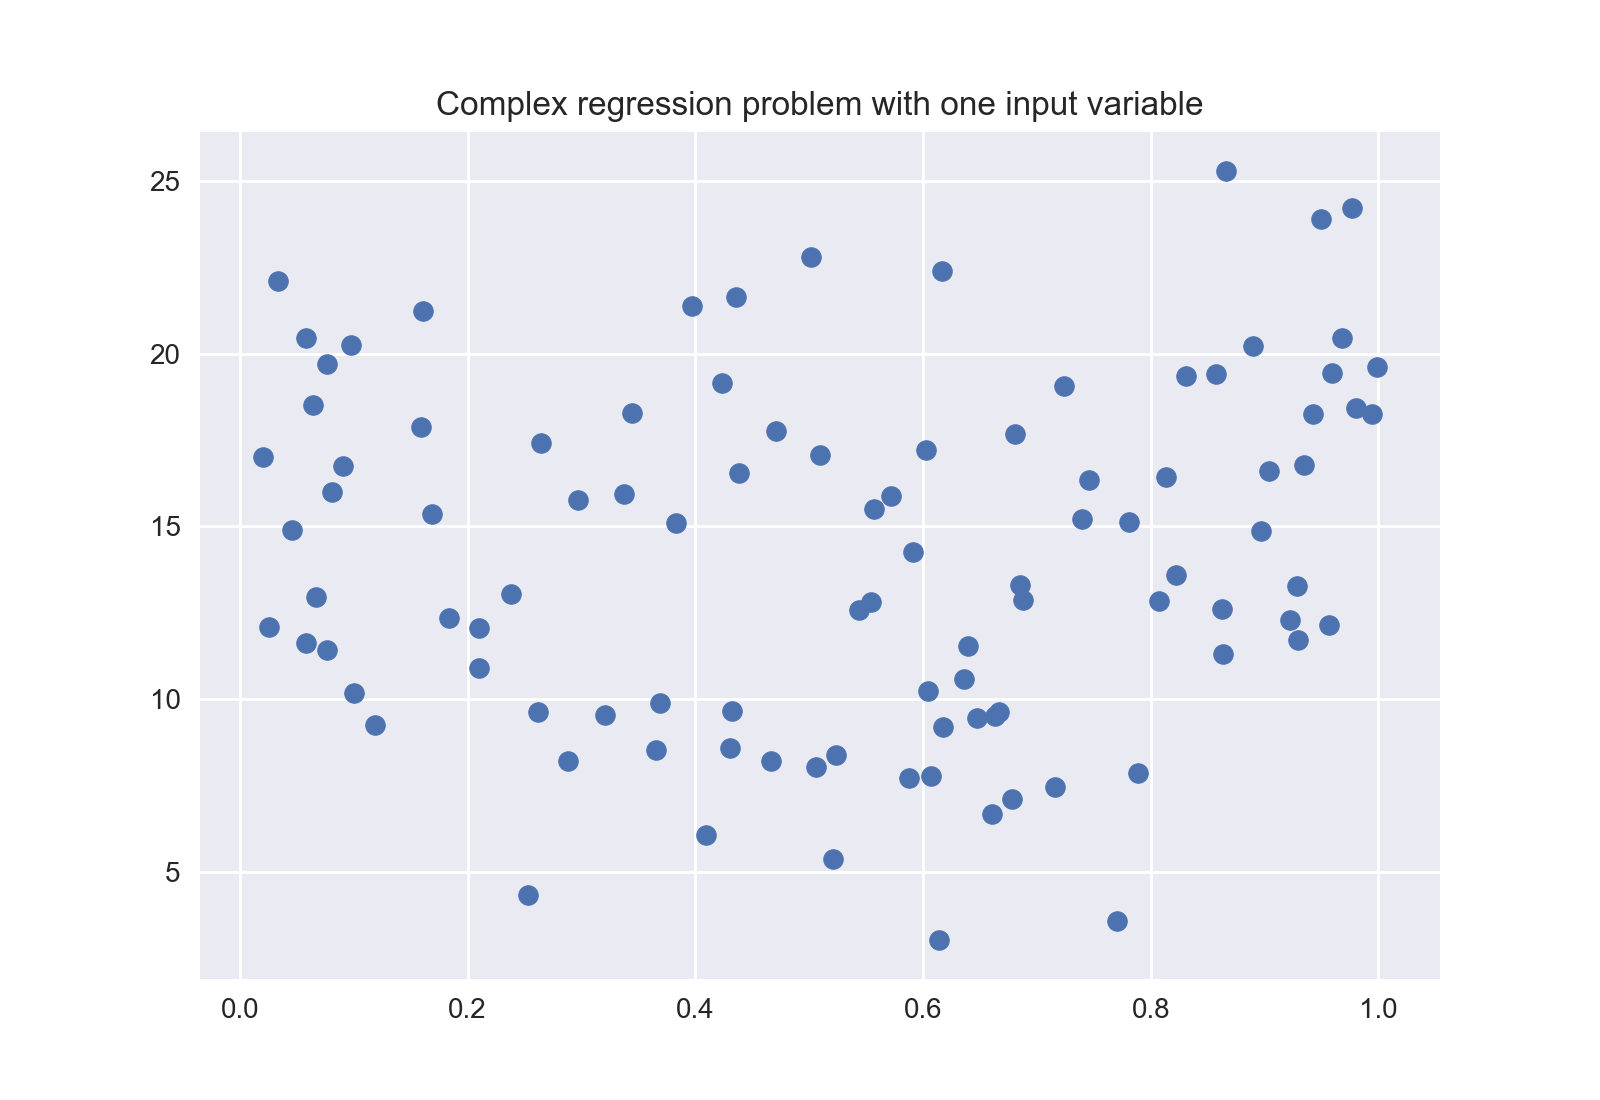

<IPython.core.display.Javascript object>


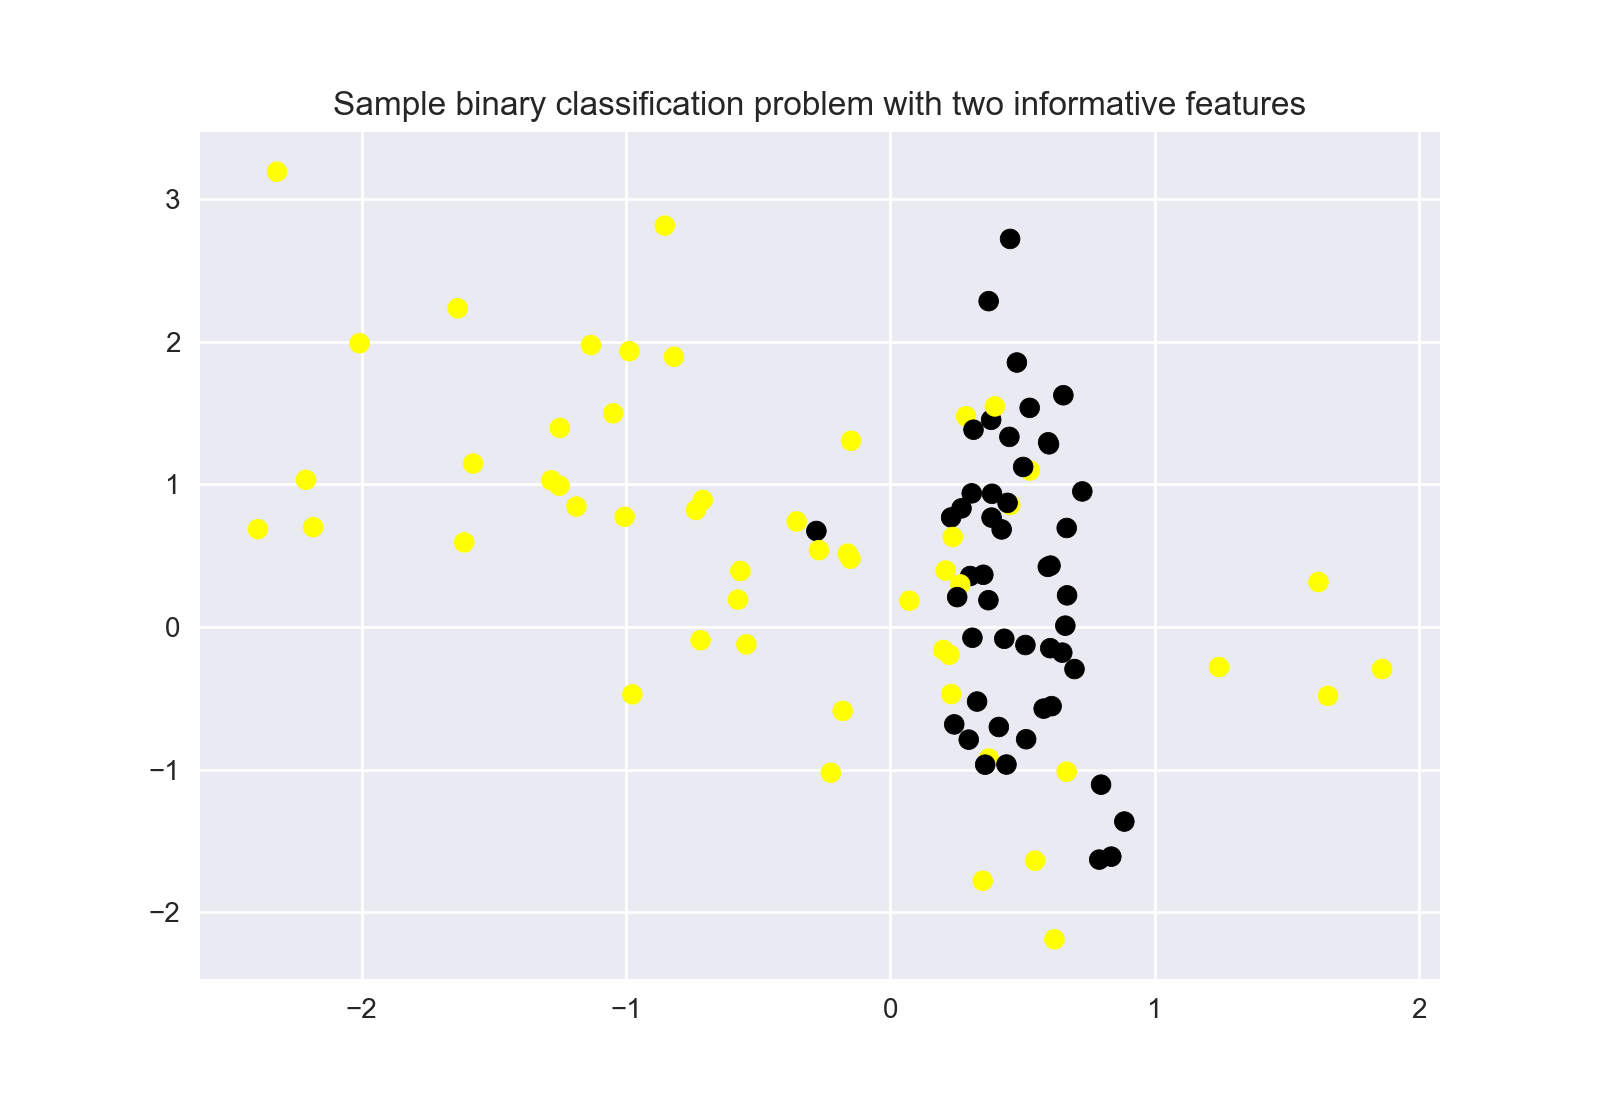

<IPython.core.display.Javascript object>


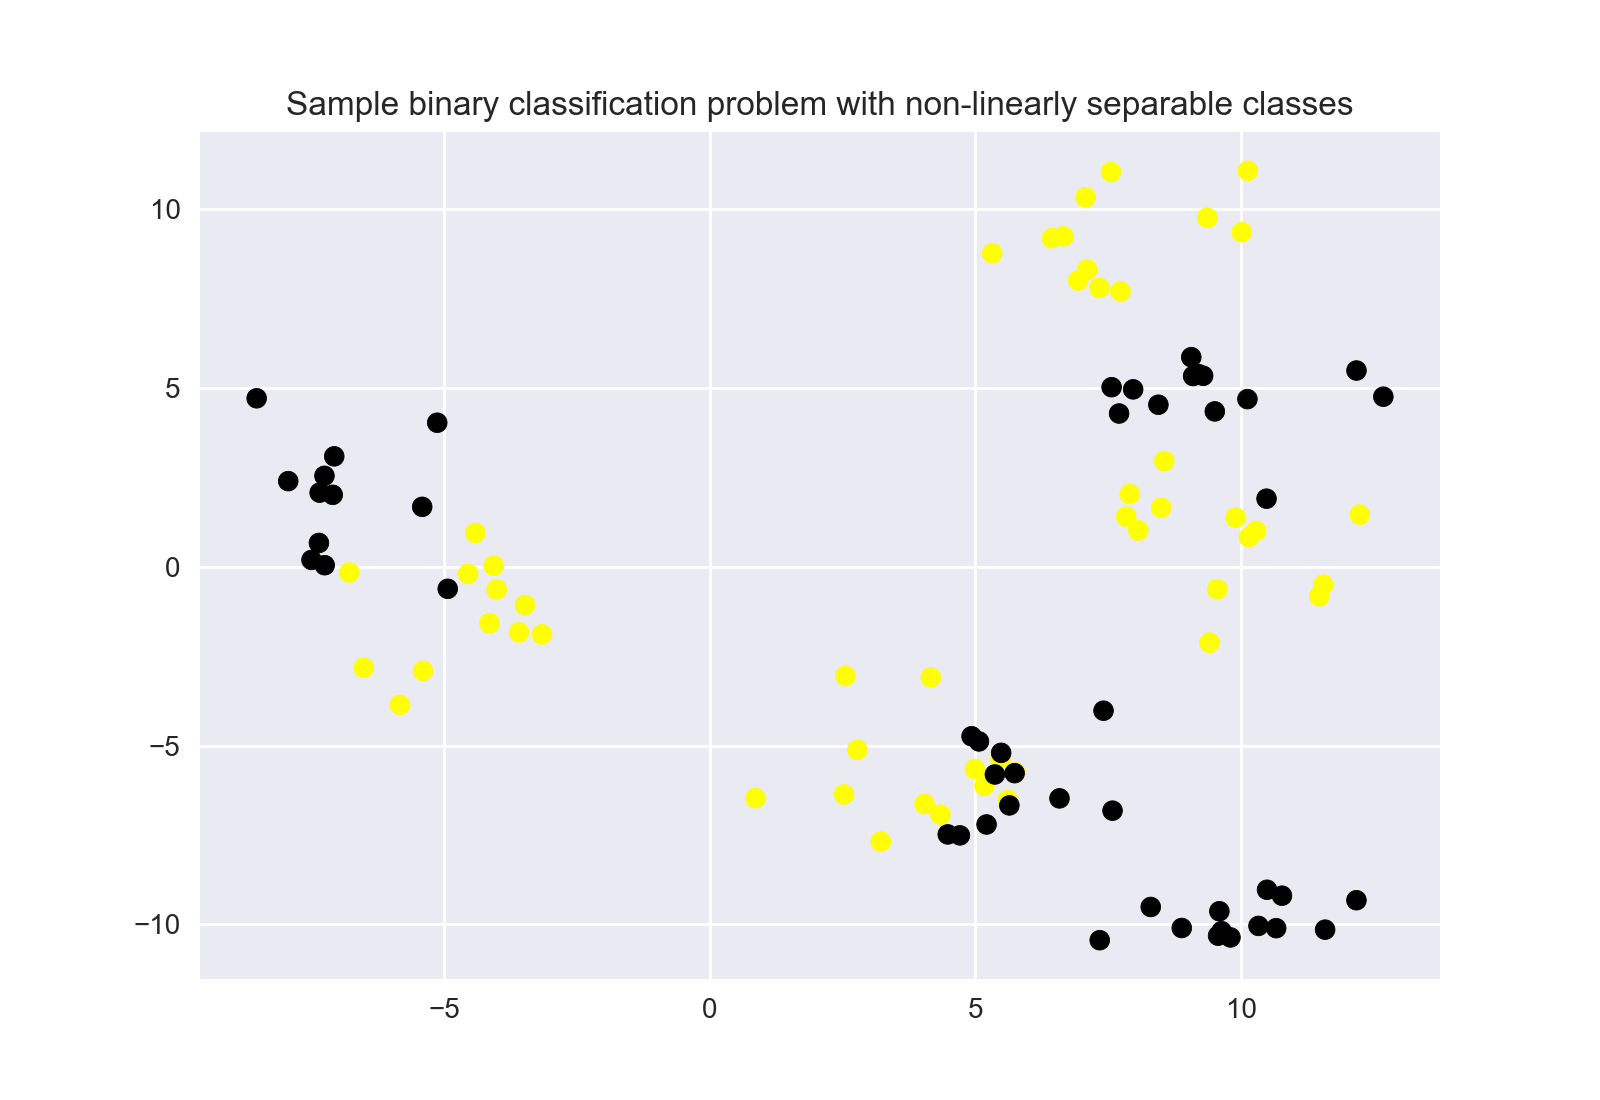

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer
from adspy_shared_utilities import load_crime_dataset


cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# fruits dataset
fruits = pd.read_table('fruit_data_with_colors.txt')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

# synthetic dataset for simple regression
from sklearn.datasets import make_regression
plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

# synthetic dataset for more complex regression
from sklearn.datasets import make_friedman1
plt.figure()
plt.title('Complex regression problem with one input variable')
X_F1, y_F1 = make_friedman1(n_samples = 100, n_features = 7,
                           random_state=0)

plt.scatter(X_F1[:, 2], y_F1, marker= 'o', s=50)
plt.show()

# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)
plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o',
           c=y_C2, s=50, cmap=cmap_bold)
plt.show()

# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset()

<a id="NBC"></a> 
## Naive Bayes classifiers

Another family of supervised learning models that's related to linear classification models is the **Naive Bayes family of classifiers, which are based on simple probabilistic models of how the data in each class might have been generated**. 

* Naive Bayes classifiers are called **naive because informally, they make the simplifying assumption that each feature of an instance is independent of all the others, given the class**. In practice, of course, this is not often the case, features often are somewhat correlated. For example, in predicting whether a house is likely to sell above the owner's asking price. Some features, such as the are of the interior rooms are likely to be correlated with other features, such as the size of the land that the house is built on or the number of bedrooms. And these features in turn might be correlated with the location of the property, and so on. 

* This naive simplifying assumption means on the one hand, that learning a Naive Bayes classifier is very fast. Because only simple per class statistics need to be estimated for each feature and applied for each feature independently. 

* On the other hand, the penalty for this efficiency is that the generalization performance of Naive Bayes Classifiers can often be a bit worse than other more sophisticated methods, or even linear models for classification. 

* Even so, especially for high dimensional data sets, Naive Bayes Classifiers can achieve performance that's often competitive to other more sophisticated methods, like support vector machines, for some tasks. 

<img src="module4_naive_bayes_1.png" alt="jupyter" style="width: 900px;"/> 

There are **three flavors of Naive Bayes Classifier** that are available in scikit learn. **The Bernoulli Naive Bayes** model uses a set of binary occurrence features. When classifying texts document for example, the Bernoulli Naive Bayes model is quit handy because we could represent the presence or the absence of the given word in the text with the binary feature. Of course this doesn't take into account how often the word occurs in the text. 

So the **Multinomial Naive Bayes** model uses a set of count base features each of which does account for how many times a particular feature such as a word is observed in training example like a document. In this lecture we won't have time to cover the Bernoulli or Multinomial Naive Bayes models. However, **those models are particularly well suited to textual data, where each feature corresponds to an observation for a particular word**. And so you'll see Naive Bayes again, including the Bernoulli and Multinomial models in more depth in the text mining part of this specialization. 

This lecture will focus on **Gaussian Naive Bayes classifiers** which assume features that are continuous or real-valued. During training, the Gaussian Naive Bayes Classifier estimates for each feature the mean and standard deviation of the feature value for each class. For prediction, the classifier compares the features of the example data point to be predicted with the feature statistics for each class, and selects the class that best matches the data point. 

More specifically, the **Gaussian Naive Bayes Classifier assumes that the data for each class was generated by a simple class specific Gaussian distribution**. Predicting the class of a new data point corresponds mathematically to estimating the probability that each classe's Gaussian distribution was most likely to have generated the data point. **Classifier then picks the class that has the highest probability**. 

<img src="module4_naive_bayes_2.png" alt="jupyter" style="width: 900px;"/> 

Without going into the mathematics involved, it can be shown that the decision boundary between classes in the two class Gaussian Naive Bayes Classifier. In general is a parabolic curve between the classes, and in the special case where the variance of these feature is the same for both classes. The decision boundary will be linear. 

<img src="module4_naive_bayes_3.png" alt="jupyter" style="width: 900px;"/> 

Here's what that looks like, typically, on a simple binary classification data set. The grey ellipses given idea of the shape of the Gaussian distribution for each class, as if we were looking down from above. You can see the centers of the Gaussian's correspond to the mean value of each feature for each class. 

More specifically, the grey ellipses show the contour line of the Gaussian distribution for each class, that corresponds to about two standard deviations from the mean. The line between the yellow and grey background areas represents the decision boundary. And we can see that this is indeed parabolic. 

<img src="module4_naive_bayes_4.png" alt="jupyter" style="width: 900px;"/> 

To use the Gaussian Naive Bayes classifier in Python, we just instantiate an instance of the Gaussian NB class and call the fit method on the training data just as we would with any other classifier. It's worth nothing that the **Naive Bayes models are among a few classifiers in scikit learn that support a method called partial fit**, which can be used instead of fit **to train the classifier incrementally** in case you're working with a huge data set that doesn't fit into memory. More details on that are available in the scikit learn documentation for Naive Bayes. 

For the Gaussian NB class **there are no special parameters to control the models complexity**. Looking at one example in the notebook from our synthetic two class dataset, we can see that, in fact, the Gaussian Naive Bayes classifier achieves quite good performance on this simple classification example. 

<IPython.core.display.Javascript object>


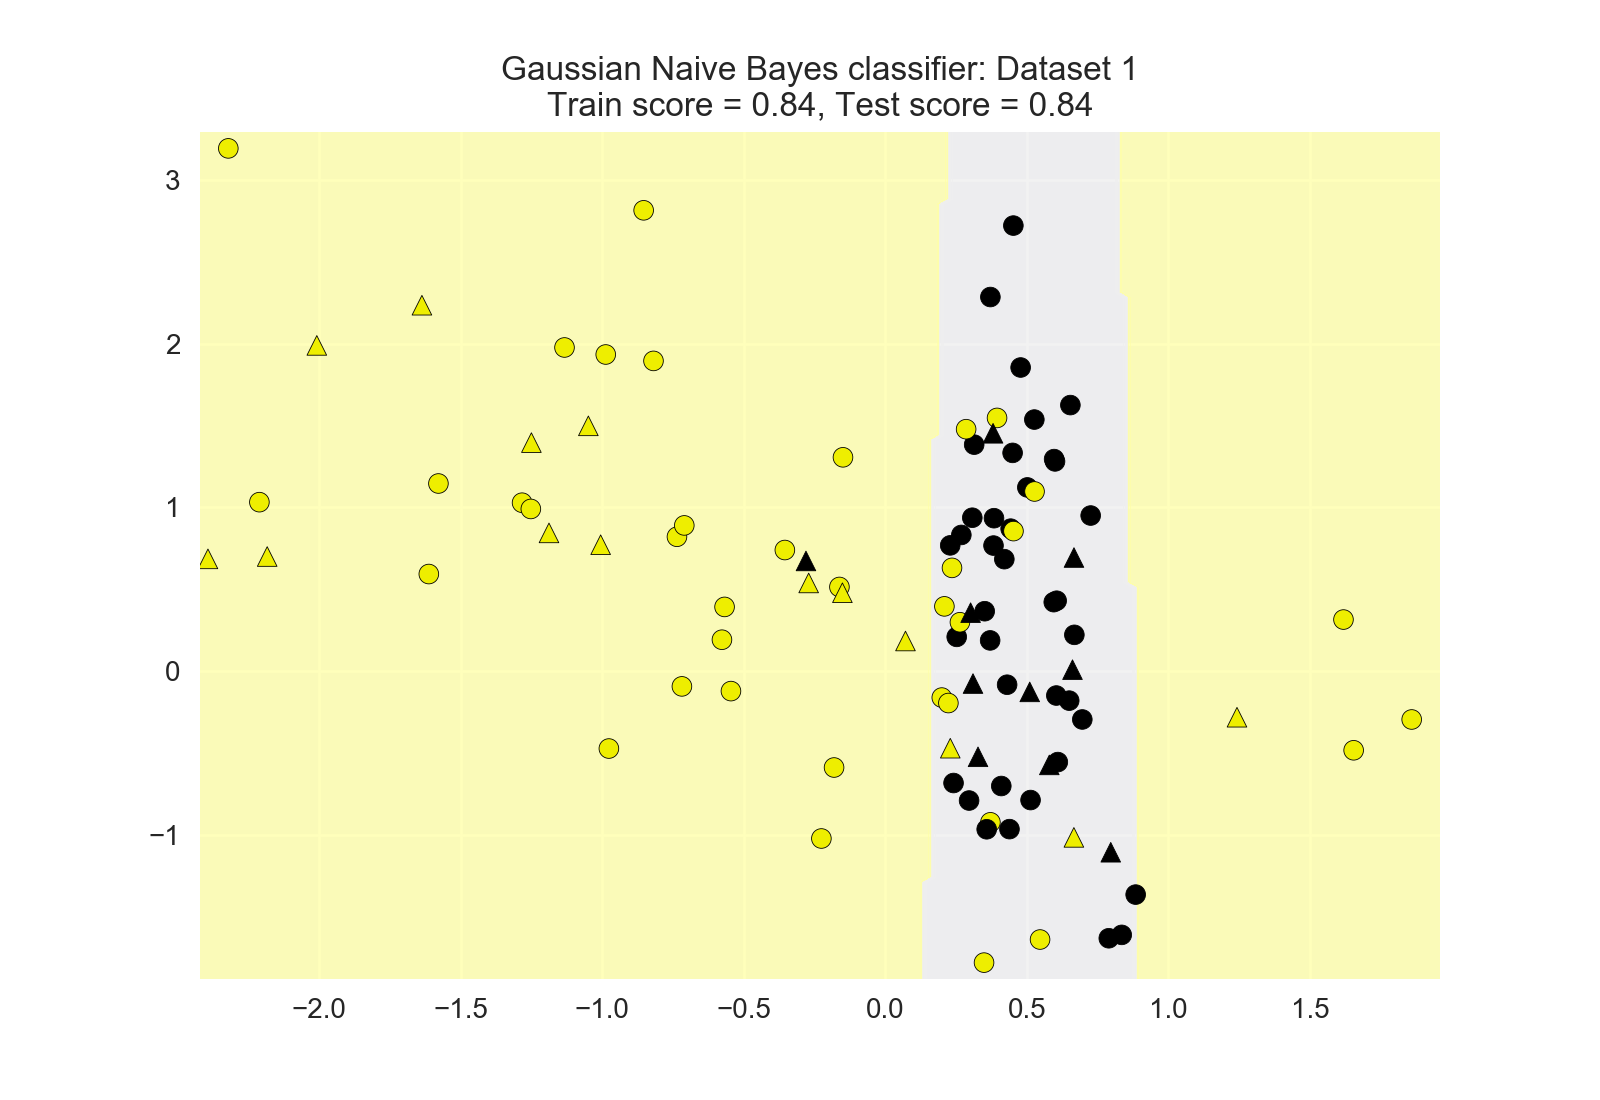

In [2]:
from sklearn.naive_bayes import GaussianNB
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 1')

When the classes are no longer as easily separable as with this second, more difficult binary example here. Like linear models, Naive Bayes does not perform as well. 

<IPython.core.display.Javascript object>


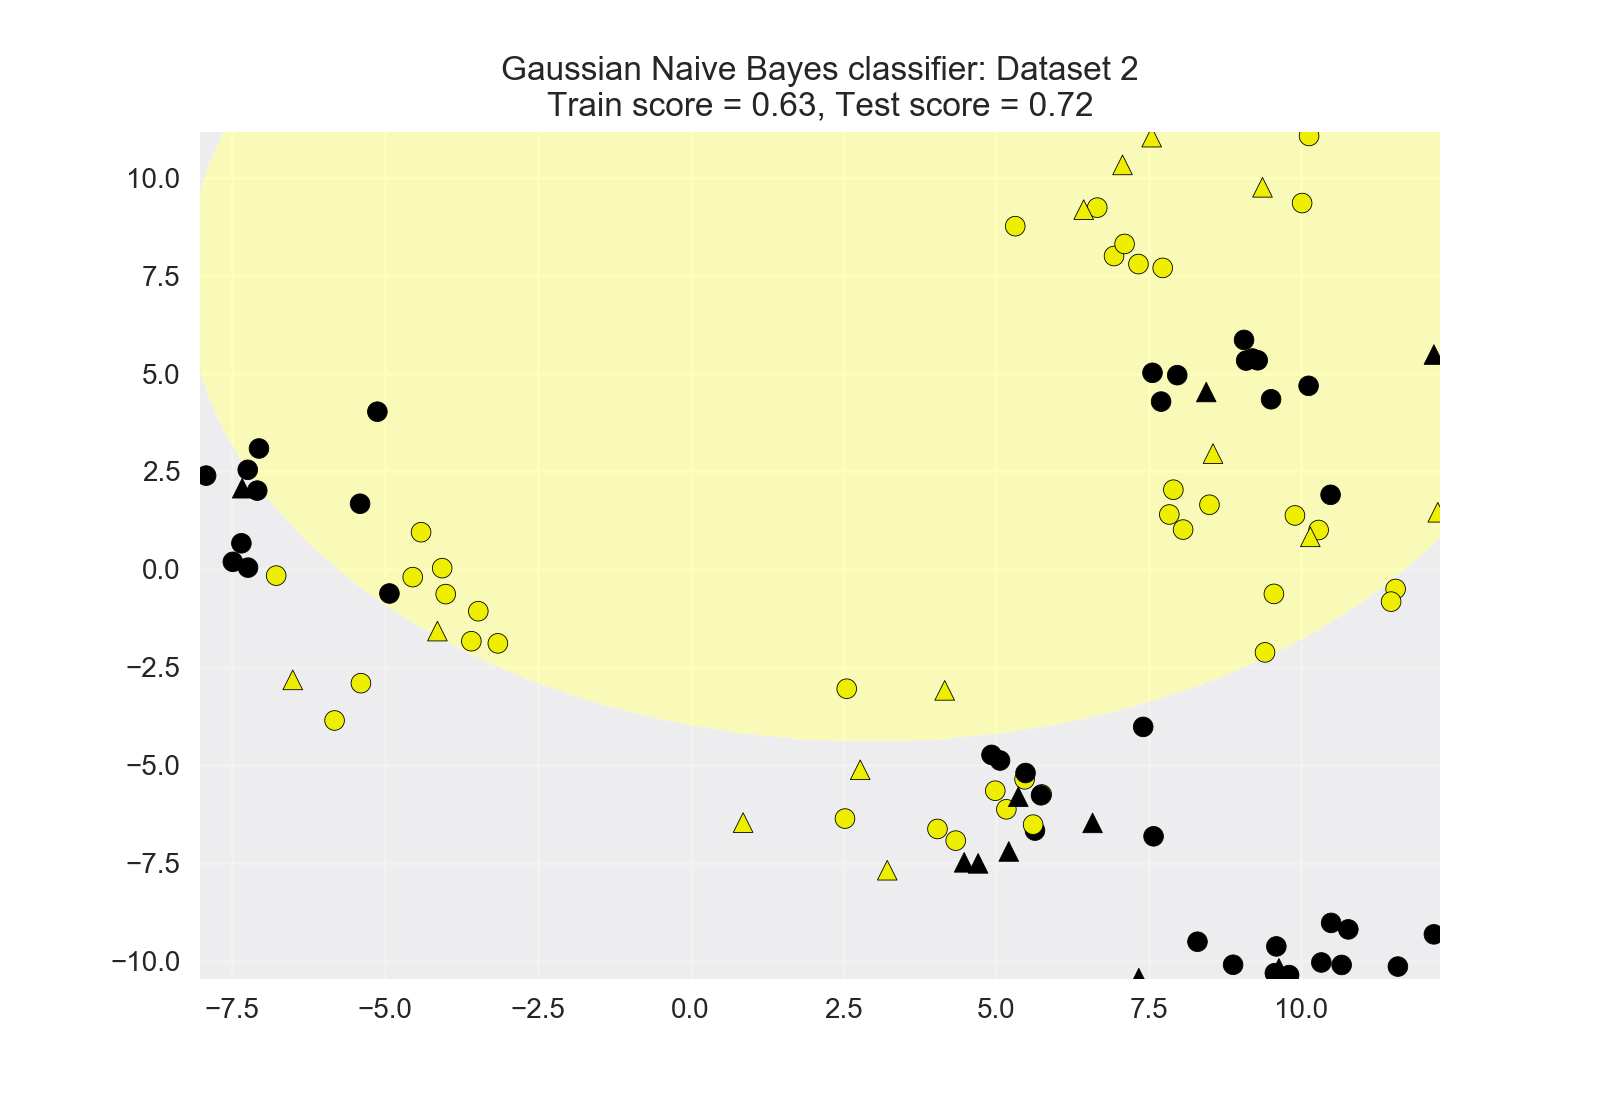

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
plot_class_regions_for_classifier(nbclf, X_train, y_train, X_test, y_test,
                                 'Gaussian Naive Bayes classifier: Dataset 2')

### Application to a real-world dataset

On a real world example, using the breast cancer data set, the Gaussian Naive Bayes Classifier also does quite well, being quite competitive with other methods, such as support vector classifiers. 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

nbclf = GaussianNB().fit(X_train, y_train)
print('Breast cancer dataset')
print('Accuracy of GaussianNB classifier on training set: {:.2f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.2f}'
     .format(nbclf.score(X_test, y_test)))

Breast cancer dataset
Accuracy of GaussianNB classifier on training set: 0.95
Accuracy of GaussianNB classifier on test set: 0.94


Typically, Gaussian Naive Bayes is used for high-dimensional data. When each data instance has hundreds, thousands or maybe even more features. And likewise the Bernoulli and Nultinomial flavors of Naive Bayes are used for text classification where there are very large number of distinct words is features and where the future vectors are sparse because any given document uses only a small fraction of the overall vocabulary. 

There's more in depth material on the Bernoulli and Multinomial Naive Bayes Classifiers in the text mining portion of this specialization. *It can be shown that Naive Bayes Classifiers are related mathematically to linear models, so many of the pros and cons of linear models also apply to Naive Bayes*. 

* On the **positive side Naive Bayes classifiers** are fast to train and use for prediction and thus are well suitable to high dimensional data including text. And the applications involving very large data sets where efficiency is critical and computational costs rule out other classification approaches. 

* On the **negative side**, when the conditional independence assumption about features doesn't hold. In other words, for a given class, there's significant covariance among features, as is the case with many real world datasets (strong correlation). Other more sophisticated classification methods that can account for these dependencies are likely to outperform Naive Bayes. On a side note, when getting confidence or probability estimates associated with predictions, Naive Bayes classifiers produce unreliable estimates, typically. 

Still, Naive Bayes Classifiers can perform very competitively on some tasks, and are also **often very useful as baseline models against which more sophisticated models can be compared**. 

<img src="module4_naive_bayes_5.png" alt="jupyter" style="width: 900px;"/> 

## Ensembles of Decision Trees

<a id="RF"></a> 
### Random forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2,
                                                   random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = RandomForestClassifier().fit(X_train, y_train)
title = 'Random Forest Classifier, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

### Random forest: Fruit dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

title = 'Random Forest, fruits dataset, default settings'
pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = RandomForestClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()

clf = RandomForestClassifier(n_estimators = 10,
                            random_state=0).fit(X_train, y_train)

print('Random Forest, Fruit dataset, default settings')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Random Forests on a real-world dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = RandomForestClassifier(max_features = 8, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset')
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

<a id="GBDT"></a> 
### Gradient-boosted decision trees

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state = 0)
fig, subaxes = plt.subplots(1, 1, figsize=(6, 6))

clf = GradientBoostingClassifier().fit(X_train, y_train)
title = 'GBDT, complex binary dataset, default settings'
plot_class_regions_for_classifier_subplot(clf, X_train, y_train, X_test,
                                         y_test, title, subaxes)

plt.show()

#### Gradient boosted decision trees on the fruit dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fruits.as_matrix(),
                                                   y_fruits.as_matrix(),
                                                   random_state = 0)
fig, subaxes = plt.subplots(6, 1, figsize=(6, 32))

pair_list = [[0,1], [0,2], [0,3], [1,2], [1,3], [2,3]]

for pair, axis in zip(pair_list, subaxes):
    X = X_train[:, pair]
    y = y_train
    
    clf = GradientBoostingClassifier().fit(X, y)
    plot_class_regions_for_classifier_subplot(clf, X, y, None,
                                             None, title, axis,
                                             target_names_fruits)
    
    axis.set_xlabel(feature_names_fruits[pair[0]])
    axis.set_ylabel(feature_names_fruits[pair[1]])
    
plt.tight_layout()
plt.show()
clf = GradientBoostingClassifier().fit(X_train, y_train)

print('GBDT, Fruit dataset, default settings')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

#### Gradient-boosted decision trees on a real-world dataset

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.1, max_depth=3)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}\n'
     .format(clf.score(X_test, y_test)))

clf = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
clf.fit(X_train, y_train)

print('Breast cancer dataset (learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GBDT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

<a id="NN"></a> 

## Neural networks

#### Activation functions

In [ ]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### Neural networks: Classification

#### Synthetic dataset 1: single hidden layer

In [ ]:
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for units, axis in zip([1, 10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

#### Synthetic dataset 1: two hidden layers

In [ ]:
from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

nnclf = MLPClassifier(hidden_layer_sizes = [10, 10], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)

plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

#### Regularization parameter: alpha

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

#### The effect of different choices of activation function

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip(['logistic', 'tanh', 'relu'], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = this_activation,
                         alpha = 0.1, hidden_layer_sizes = [10, 10],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Neural networks: Regression

In [ ]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

#### Application to real-world dataset for classification

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, random_state = 0)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs').fit(X_train_scaled, y_train)

print('Breast cancer dataset')
print('Accuracy of NN classifier on training set: {:.2f}'
     .format(clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

In [1]:
!find . -maxdepth 1 -not -type d

./addresses.csv
./train.csv
./Module 2.ipynb
./Assignment 3.ipynb
./Module 4.ipynb
./Assignment 1.ipynb
./test.csv
./CommViolPredUnnormalizedData.txt
./adspy_shared_utilities.py
./Module 3.ipynb
./fraud_data.csv
./fruit_data_with_colors.txt
./Assignment 4.ipynb
./Assignment 2.ipynb
./mushrooms.csv
./Classifier Visualization.ipynb
./latlons.csv
./Module 1.ipynb


In [7]:
!ls readonly

addresses.csv  adspy_temp.dot  polynomialreg1.png  train.csv


In [8]:
!cp ./Module 2.ipynb readonly/Module 2.ipynb

cp: target ‘2.ipynb’ is not a directory
